### Deal with imbalanced data set

In [63]:
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

### Load the data
Choose columns as features. Shuffle the data set

In [116]:
def load_data(csv_file):
    """Load the feature and label csv file"""
    df = pd.read_csv(csv_file)
    df = df[["Complaint ID", "Timely response?", "Product", "corpus_score_sum", "word_num", "sentence_num", "negative_ratio", "most_negative_score", "company_response", "dispute"]]
    
    #Add average sentiment score 
    df.insert(3, "corpus_score_ave", df["corpus_score_sum"] / df["sentence_num"])
    
    df = shuffle(df)
    return df

feature_file = "data/complaints_with_sentiment_metric.csv"
complaints = load_data(feature_file)




In [117]:
complaints.head()

,Complaint ID,Timely response?,Product,corpus_score_ave,corpus_score_sum,word_num,sentence_num,negative_ratio,most_negative_score,company_response,dispute
38205,2334174,Yes,Consumer Loan,-0.13168,-0.6584,119,5,0.4,-0.5106,Closed with explanation,0
70026,1928596,Yes,Bank account or service,0.00000,0.0000,52,4,0.0,0.0000,Closed with explanation,0
46431,2062529,Yes,Bank account or service,-0.07547,-0.7547,84,10,0.4,-0.6369,Closed with explanation,0
22682,2161058,Yes,Mortgage,0.29600,0.2960,51,1,0.0,0.0000,Closed with explanation,0
152013,2230040,Yes,Credit reporting,-0.14427,-1.4427,200,10,0.4,-0.8519,Closed with explanation,0


In [12]:
complaints["Timely response?"].value_counts()

Yes    157933
No       6143
Name: Timely response?, dtype: int64

In [16]:
complaints[complaints["Timely response?"] == "No"].head()

,Complaint ID,Timely response?,Product,corpus_score_sum,word_num,sentence_num,negative_ratio,most_negative_score,company_response,dispute
119430,2176234,No,Debt collection,-0.4323,133,8,0.250000,-0.7824,Closed with explanation,0
65791,2241150,No,Debt collection,-4.2865,196,11,0.636364,-0.8271,Closed with explanation,0
16738,2441402,No,Debt collection,-1.0542,525,14,0.428571,-0.8958,Closed with explanation,0
93439,1762208,No,Debt collection,-1.2950,214,10,0.300000,-0.7902,Untimely response,0
15441,2103346,No,Debt collection,-1.1502,279,4,0.500000,-0.9830,Closed,0


### Preprocessing the data
one hot coding, scale some columns, train_test_split

In [102]:
def preprocessing_data(df):
    """Generate training and test data. one hot coding for categorical columns. Scale
    real value columns using MinMaxScaler. """
    X = df.loc[:, "corpus_score_ave":"company_response"]
    #X = df.loc[:, "Timely response?":"company_response"]
    y = df["dispute"]
    
    old_column_num = len(X.columns)
    
    # One hot coding for category data
    X = pd.get_dummies(X)
    #print(X.columns)

    # Get the new columns increased by one hot coding. Prepare to add to data to be predicted
    new_column_names = []
    for i in np.arange(old_column_num - 1, len(X.columns)):
        new_column_names.append(X.columns[i])
    #print(new_column_names)
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=1)

    # Scale the data, only scale word_num and sentence_num because the other column value
    # are in range of [-1, 1] TODO: consider better scale
    scaler = MinMaxScaler()
    scaler.fit(X_trainval.loc[:, ["word_num", "sentence_num"]])

    X_trainval.loc[:, ["word_num", "sentence_num"]] = scaler.transform(X_trainval.loc[:, ["word_num", "sentence_num"]])
    X_test.loc[:, ["word_num", "sentence_num"]] = scaler.transform(X_test.loc[:, ["word_num", "sentence_num"]])
    #print(X_test.head())

    # Save the new column names to a file
    column_name_file = "result/column_names.csv"
    with open(column_name_file, "w") as fobj:
        fobj.write(",".join(new_column_names))

    return X_trainval, X_test, y_trainval, y_test


In [118]:
X_trainval, X_test, y_trainval, y_test = preprocessing_data(complaints)

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [119]:
X_trainval_res, y_trainval_res = smote_over_sampling(X_trainval, y_trainval)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3abfa1d0>,
      dtype=object)

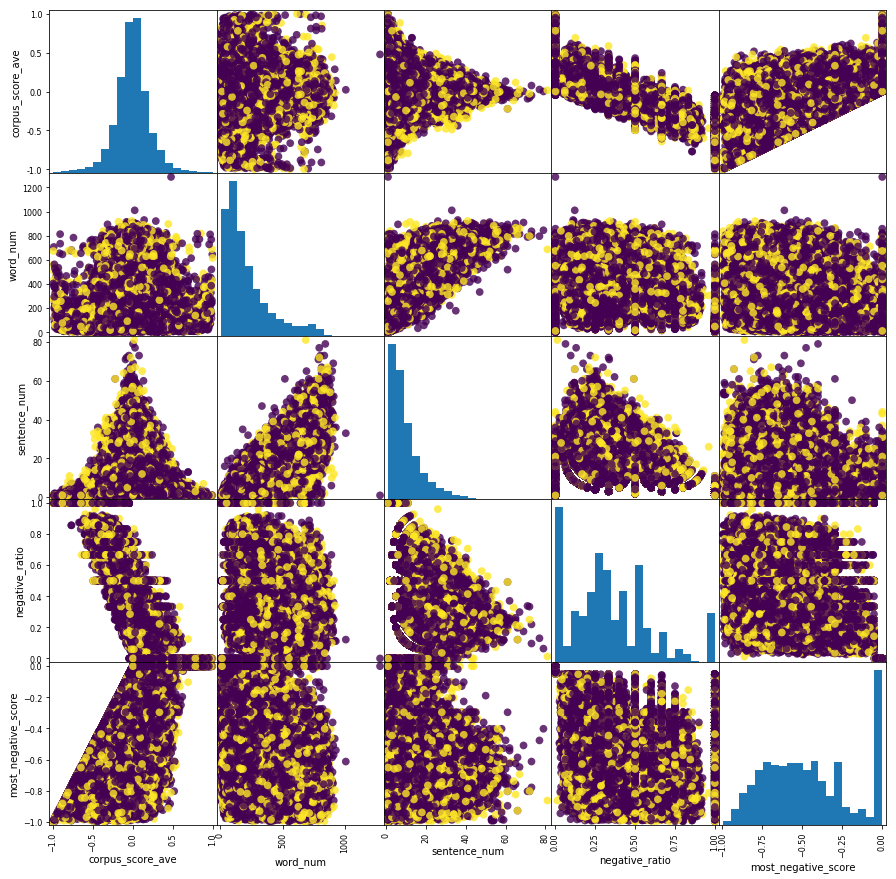

In [105]:
pd.plotting.scatter_matrix(complaints.loc[:, "corpus_score_ave":"most_negative_score"], c=complaints["dispute"], figsize=(15,15), marker='o', hist_kwds={"bins":20}, s=60, alpha=.8)

### Random under sample 

In [106]:
rus = RandomUnderSampler(random_state=42)
X_under_res, y_under_res = rus.fit_resample(complaints.loc[:, "corpus_score_ave":"most_negative_score"], complaints["dispute"])

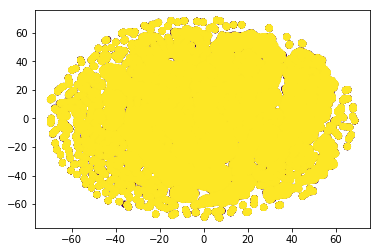

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
X_under_res_tsne = tsne.fit_transform(X_under_res)
plt.scatter(X_under_res_tsne[:,0], X_under_res_tsne[:,1],c=y_under_res)

In [107]:
pca = PCA(n_components=2)
pca.fit(X_under_res)
X_under_res_pca = pca.transform(X_under_res)
plt.scatter(X_under_res_pca[:,0], X_under_res_pca[:, 1], c = y_under_res)



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a478db748>,
      dtype=object)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a1e6a98c8> (for post_execute):


KeyboardInterrupt: 

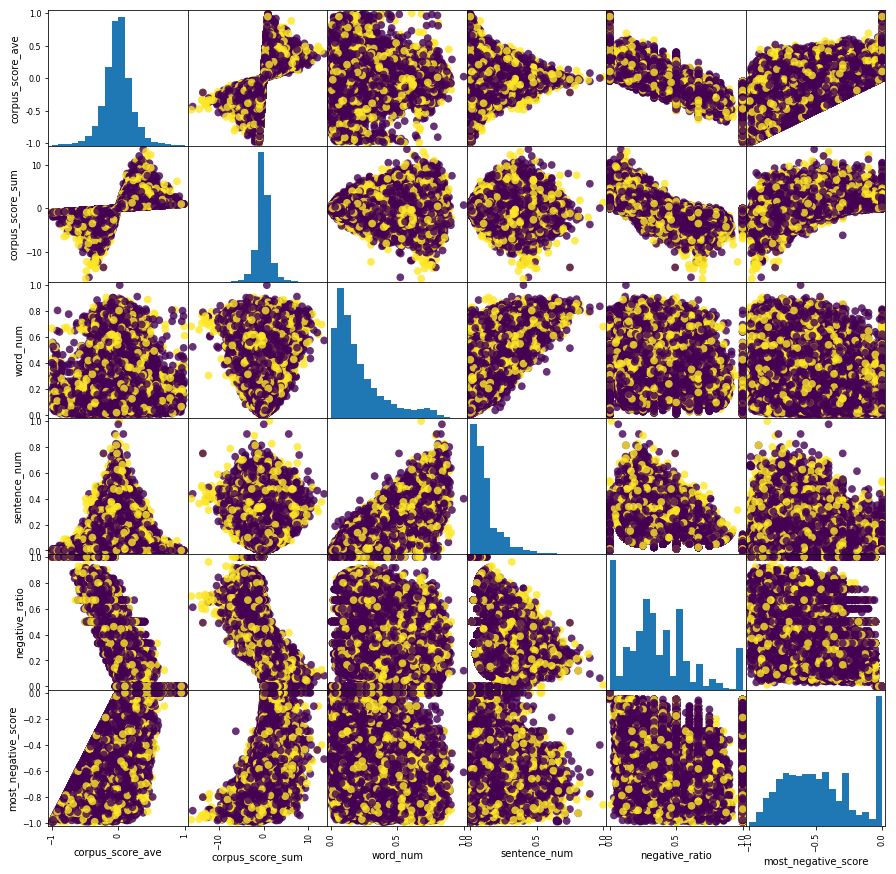

In [120]:
pd.plotting.scatter_matrix(X_trainval.loc[:, "corpus_score_ave":"most_negative_score"], c=y_trainval, figsize=(15,15), marker='o', hist_kwds={"bins":20}, s=60, alpha=.8)

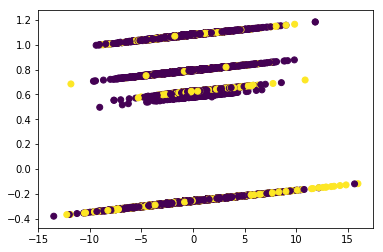

In [23]:

pca = PCA(n_components=2)
pca.fit(X_trainval)

X_trainval_pca = pca.transform(X_trainval)

plt.scatter(X_trainval_pca[:,0], X_train_pca[:,1], c=y_trainval)


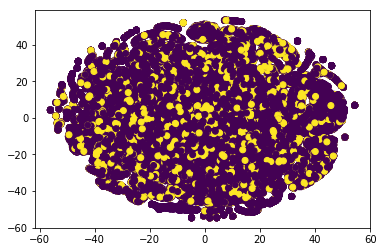

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
X_trainval_tsne = tsne.fit_transform(X_trainval)
plt.scatter(X_trainval_tsne[:,0], X_trainval_tsne[:,1],c=y_trainval)

### Both PCA and t-NSE show the data set is not separable. Does this mean that the features are not enough to separate them?

In [110]:
def smote_over_sampling(X_train, y_train):
    #use SMOTE to oversampling X, y
    #x_columns_name = X_train.columns
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    #X_train_res = pd.DataFrame(X_train_res, columns=x_columns_name)
    #y_train_res = y_train_res.ravel()
    return X_train_res, y_train_res


In [111]:
def model_evaluate(model, X_test, y_test, is_rf=False):
    """Evaluate model by accuracy, confusion matrix and f1 score"""
    pred_model = model.predict(X_test)
    confusion = confusion_matrix(y_test, pred_model)
    print("Confusion matrix:\n{}".format(confusion))
    print("f1 score: {:.2f}".format(f1_score(y_test, pred_model)))
    
    #Computing the AUC score as the criteria for the imbalance data
    if is_rf == True:
        model_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        #plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    else:
        model_auc = roc_auc_score(y_test, model.decision_function(X_test))
        #plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))
        
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.savefig("figs/roc.png")
        
    print("AUC for model is: {:.3f}".format(model_auc))
    

### Classification and ROC / AUC analysis

In [112]:
def auc_analysis(classifier, X, y, useSMOTE):
    cv = StratifiedKFold(n_splits=6)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        X = np.array(X)
        y = np.array(y)
        
        if useSMOTE == True:
            X_train_res, y_train_res = smote_over_sampling(X[train], y[train])
            probas_ = classifier.fit(X_train_res, y_train_res).predict_proba(X[test])
        else :
            probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        # Store roc_auc of each cv fold 
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return mean_auc, std_auc
        

### Random forest without oversampling

Train the data using the crossvalidation to see whether random forest model has large variation

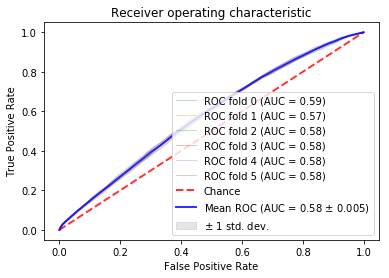

In [121]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
useSMOTE=False
mean_auc, std_auc = auc_analysis(rf, X_trainval, y_trainval, useSMOTE)

In [114]:
print("AUC of random forest model: {:.3f} +- {:.3f}".format(mean_auc, std_auc))

AUC of random forest model: 0.580 +- 0.003


Confusion matrix:
[[30752  1325]
 [ 8260   682]]
f1 score: 0.12
AUC for model is: 0.581


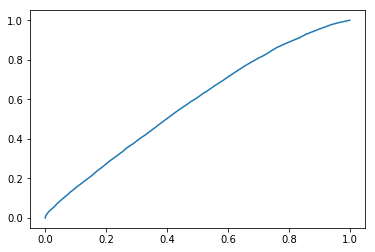

In [115]:
rf.fit(X_trainval, y_trainval)
model_evaluate(rf, X_test, y_test, True)

Confusion matrix:
[[30616  1349]
 [ 8368   686]]
f1 score: 0.12
AUC for model is: 0.582


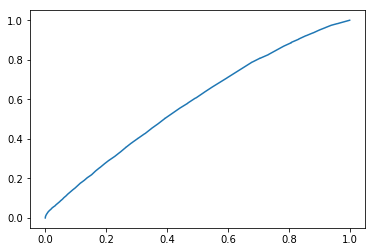

In [43]:
rf.fit(X_trainval, y_trainval)
model_evaluate(rf, X_test, y_test, True)

### Random forest with oversampling

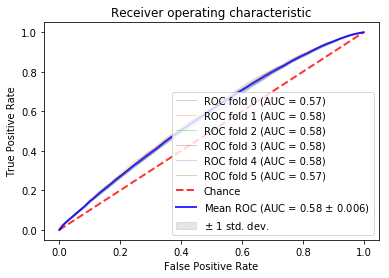

AUC of random forest model: 0.577 +- 0.006


In [47]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
mean_auc, std_auc = auc_analysis(rf, X_trainval, y_trainval, True)
print("AUC of random forest model: {:.3f} +- {:.3f}".format(mean_auc, std_auc))

Confusion matrix:
[[26391  5574]
 [ 6854  2200]]
f1 score: 0.26
AUC for model is: 0.576


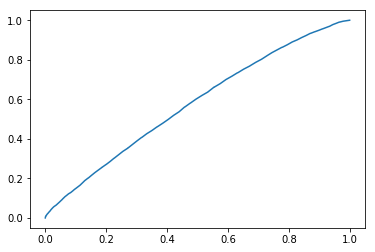

In [29]:
#Test on X_test using random forest model trained with over sampling data
rf.fit(X_trainval_res, y_trainval_res)
model_evaluate(rf, X_test, y_test, True)

In [ ]:
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=0)
mean_auc, std_auc = auc_analysis(classifier, X_trainval, y_trainval)
print("AUC of linear SVM model: {:.3f} +- {:.3f}".format(mean_auc, std_auc))

In [69]:
def choose_lgreg_param(X, y, useSMOTE):
    """Choose best parameter for logistic regression"""
    mean_auc_list = []
    std_auc_list = []
    for c in [0.01, 0.1, 1, 10]:
        lgreg = LogisticRegression(C=c, solver="lbfgs", max_iter=2000)
        
        mean_auc, std_auc = auc_analysis(lgreg, X, y, useSMOTE)
        mean_auc_list.append(mean_auc)
        std_auc_list.append(std_auc_list)
        print("Parameter C={:.3f}, mean_auc: {:.4f}, std_auc: {:.4f}".format(c, mean_auc, std_auc))
        
    return mean_auc_list, std_auc_list
        

    

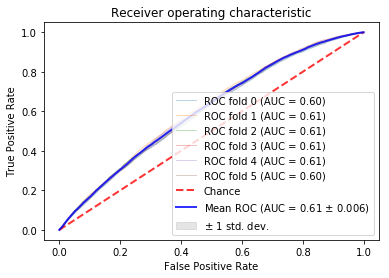

Parameter C=0.010, mean_auc: 0.6069, std_auc: 0.0056


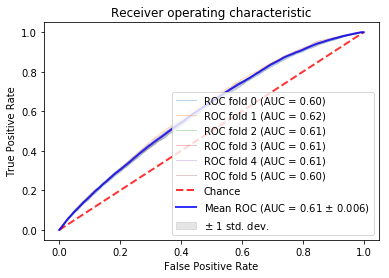

Parameter C=0.100, mean_auc: 0.6080, std_auc: 0.0057


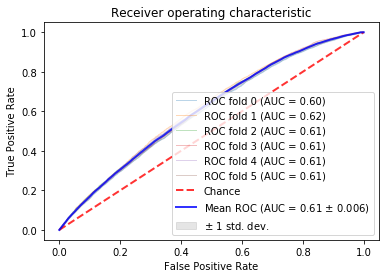

Parameter C=1.000, mean_auc: 0.6081, std_auc: 0.0057


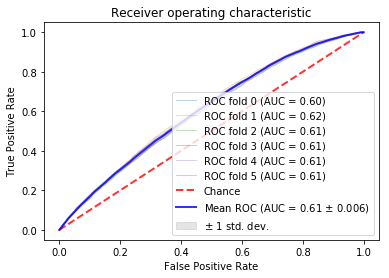

Parameter C=10.000, mean_auc: 0.6081, std_auc: 0.0057


In [70]:
mean_auc_list, std_auc_list = choose_lgreg_param(X_trainval, y_trainval, useSMOTE=False)

The best parameter for logistic regression is C = 1. Apply it to test data

Confusion matrix:
[[31965     0]
 [ 9054     0]]
f1 score: 0.00
AUC for model is: 0.610


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


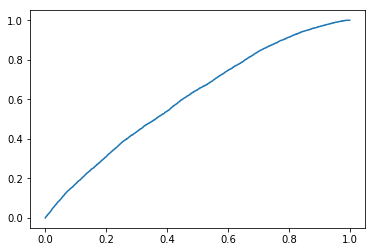

In [73]:
lgreg = LogisticRegression(C=1, solver="lbfgs", max_iter=2000)
lgreg.fit(X_trainval, y_trainval)
is_rf = False
model_evaluate(lgreg, X_test, y_test, is_rf)


### Logistic regression roc after oversampling by SMOTE

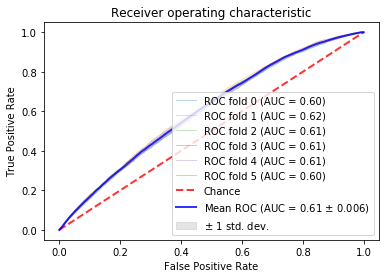

Parameter C=0.010, mean_auc: 0.6074, std_auc: 0.0057


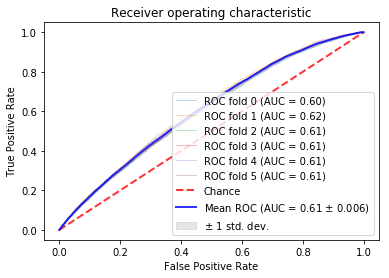

Parameter C=0.100, mean_auc: 0.6080, std_auc: 0.0057


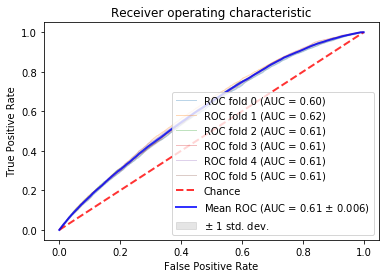

Parameter C=1.000, mean_auc: 0.6081, std_auc: 0.0057


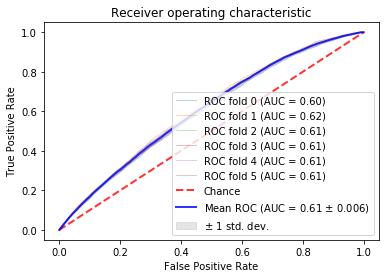

Parameter C=10.000, mean_auc: 0.6080, std_auc: 0.0057


In [74]:
mean_auc_list, std_auc_list = choose_lgreg_param(X_trainval, y_trainval, useSMOTE=True)

### The best parameter for logistic regression is also C = 1
Compared to the model without smote, smote generate slightly lower mean_auc, less std_auc. Let's see how it performs on test data.

Confusion matrix:
[[15431 16534]
 [ 3026  6028]]
f1 score: 0.38
AUC for model is: 0.609


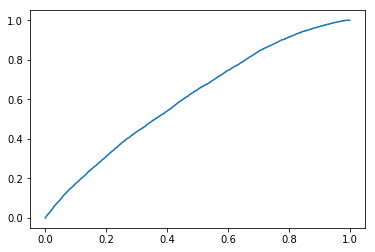

In [75]:
lgreg = LogisticRegression(C=1, solver="lbfgs", max_iter=2000)
lgreg.fit(X_trainval_res, y_trainval_res)
model_evaluate(lgreg, X_test, y_test, False)

In [92]:
lgreg.predict(X_test)[:20] == y_test[:20]

104272    False
44561      True
39368     False
2401       True
86577      True
91971      True
67940     False
85503     False
650       False
109605    False
151133     True
162281     True
162845     True
77976     False
88630      True
40552      True
140823    False
102114    False
77020     False
52063     False
Name: dispute, dtype: bool

In [81]:
X_test.iloc[0, :] 

corpus_score_sum                                   -2.127500
word_num                                            0.171984
sentence_num                                        0.087500
negative_ratio                                      0.625000
most_negative_score                                -0.588800
company_response_Closed                             0.000000
company_response_Closed with explanation            1.000000
company_response_Closed with monetary relief        0.000000
company_response_Closed with non-monetary relief    0.000000
company_response_None                               0.000000
company_response_Untimely response                  0.000000
Name: 104272, dtype: float64

In [78]:
y_test[:20]

104272    0
44561     0
39368     1
2401      0
86577     0
91971     1
67940     1
85503     0
650       0
109605    0
151133    1
162281    0
162845    0
77976     1
88630     0
40552     1
140823    0
102114    1
77020     1
52063     1
Name: dispute, dtype: int64

In [94]:
complaints.loc[[39368]]

,Complaint ID,Timely response?,Product,corpus_score_sum,word_num,sentence_num,negative_ratio,most_negative_score,company_response,dispute
39368,2066267,Yes,Credit card,-0.6751,31,2,1.0,-0.4019,Closed with monetary relief,1


In [87]:
complaints_with_narrative = pd.read_csv("data/complaints_with_sentiment_metric.csv")

In [93]:
complaints_with_narrative.loc[[39368], "Consumer complaint narrative"].values

array(['I have filed a dispute with XXXX XXXX. I now can prove my charges were not real and I have asked you to call me and emailed several times.'],
      dtype=object)

### Try undersampling of the data

In [48]:
complaints["dispute"].value_counts()

0    128269
1     35807
Name: dispute, dtype: int64

In [ ]:
def undersampling(X_train, y_train):
    